In [4]:
%matplotlib notebook
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import sys
import pandas as pd

In [5]:
import qcodes as qc
from qcodes import load_by_id
from qcodes import validators
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.database import initialise_database
from qcodes.instrument.base import Instrument
from qcodes.instrument.parameter import Parameter
from pytopo.qctools.instruments import create_inst
from pytopo.qctools.dataset2 import select_experiment

from plottr import client
from plottr.qcodes_dataset import QcodesDatasetSubscriber

from pytopo.mplplots.init_nb_plotting import *

qc.config['core']['db_location'] = r"d:/OneDrive/BF2/Data/experiments.db"

In [6]:
sys.path.append('D:/OneDrive/BF2/Code')
from RF_conductance.tools import rf_cond_find_conversion, convert_rf

In [5]:
def colorplot(data, fast_s, slow_s, z, d_z = False):
    fig=plt.figure()
    plt.title('run ID: ' + '{}'.format(data.run_id))
    #data = data[0]
    fs = np.unique(data.get_values(fast_s))
    ss = np.unique(data.get_values(slow_s))
    #print((data.get_values(slow_s)))
    if not d_z:
        data_z = np.array(data.get_values(z)) 
    else:
        data_z = z
    #r_line = 23.4e3
    #conductance = 12906/(2e-5/(data_z/1e6) - r_line)
    conductance = data_z
    #print(min(conductance), max(conductance))
    cmap = plt.cm.seismic #seismic, viridis, magma
    norm = mpl.colors.Normalize(vmin=0, vmax=0.3) #min(conductance) min(conductance)
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.ax.set_ylabel(r'dI/dV ($G_0$)')
    plt.pcolor(np.unique(fs)[::-1]*1e3, np.unique(ss)[::-1], np.reshape(conductance,(len(np.unique(ss)),len(np.unique(fs)))), cmap=cmap, norm=norm)
    #plt.xlabel(fast_s + ' (V)')
    #plt.ylabel(slow_s + ' (V)')
    plt.xlabel(fast_s)
    plt.ylabel(slow_s)
    #plt.tight_layout()
    #plt.savefig(r'D:\Data\images\20180711_' + str(dat2D.exp_name) +'.png')
    #plt.xlim(-0.011,0.011)
    #plt.ylim(0.1,0.3)

In [ ]:
colorplot(dat, 'lockin_dc', 'mdac_gate_voltage', 'Lockin1_X')

In [6]:
def plot1D_from_2D(data, x, y, x2, index):
    b = np.unique(np.array(data.get_values(x))) #[::-1]
    print(b)
    npoints = len(b)
    v2 = np.array(data.get_values(x2))
    x2_value = v2[index*npoints]
    points = v2 == v2[index*npoints]#x2_value #np.abs((v2 - x2_value)/x2_value) < 1e-6 #v2 == x2_value   # np.abs((v2 - x2_value)/x2_value) < 1e-6
    
    #plt.plot(points)
    g = np.array(data.get_values(y))
    g = g[points]
    #g = smooth(g, 21, 3)
    #g_sub = curr2cond(g, 20e-6, 15e3)
    #print(b, g)
    print(x2_value)
    plt.plot(b, g[::-1], label=x2+' = '+str(x2_value)[1:4]+' T')
    plt.xlabel(x+' (V)')
    plt.ylabel('dI/dV (G0)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(r'D:\Data\images\20180711_' + str(dat2D.exp_name) + '_%.3fT.png'%(x2_value))
    
    #return b #, g_sub

In [ ]:
plt.figure()
dat2D.get_parameters()#values('conductance')
plot1D_from_2D(dat2D, 'mdac_gate_voltage', 'conductance', 'AMI430_z_field', 7)
dat2D.run_id = 615

result of nonzero function:  (array([0], dtype=int64), array([0], dtype=int64))


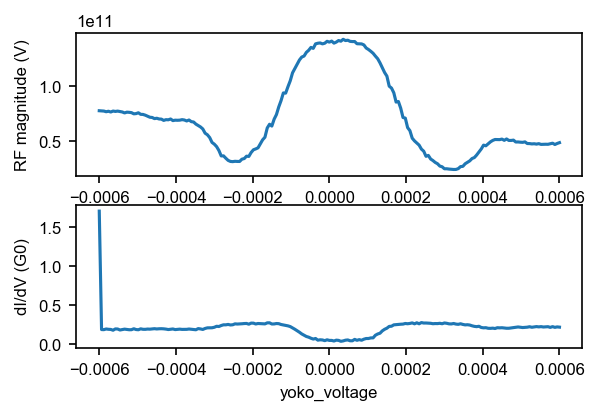

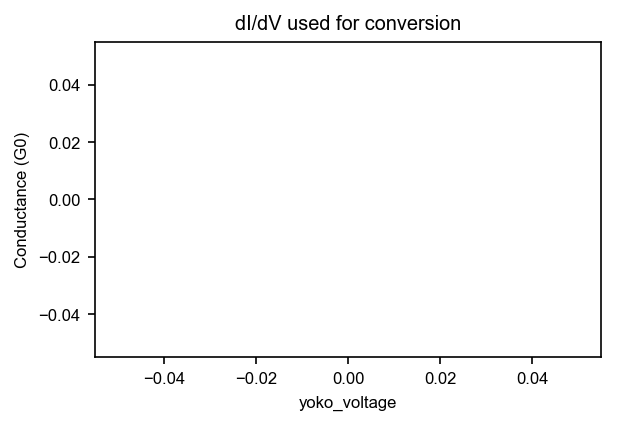

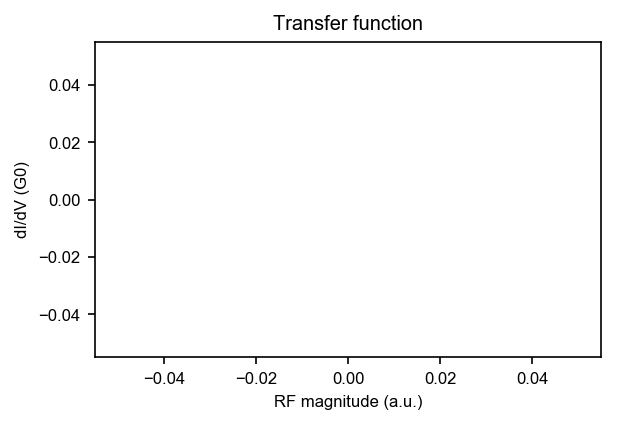

In [5]:
rf_cal, dIdV_cal = rf_cond_find_conversion(406, 'yoko_voltage', 'ivvi_setup_g2_measurement', 'logmag_dev48')

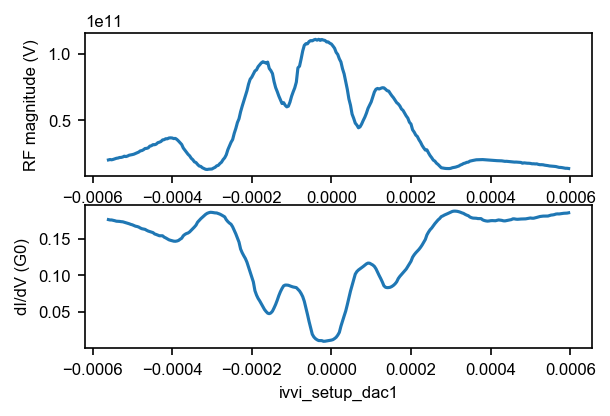

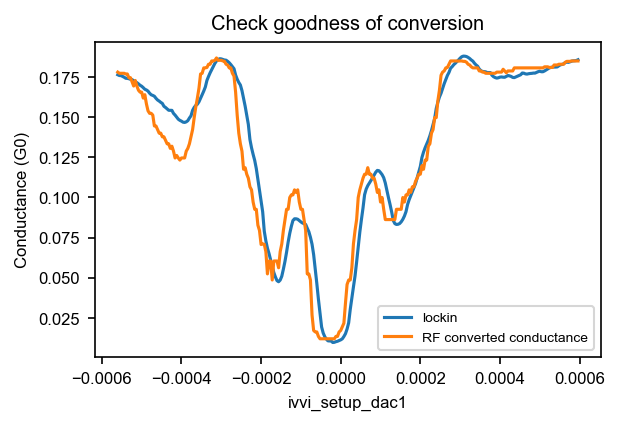

In [5]:
convert_rf(160, 'ivvi_setup_dac1', 'lockin3_X', 'logmag', rf_cal, dIdV_cal, cut_init=10)

### Calibration curve

In [74]:
dat = load_by_id(413)
dat.get_parameters

<bound method DataSet.get_parameters of results #413@d:/OneDrive/BF2/Data/experiments.db
------------------------------------------------
yoko_voltage - numeric
logmag_dev48 - numeric
phase_dev48 - numeric
logmag_dev12 - numeric
phase_dev12 - numeric
ivvi_setup_g3_measurement - numeric
ivvi_setup_g2_measurement - numeric>

In [75]:
Vb = dat.get_values('yoko_voltage') #ivvi_setup_dac1
RF_mag_cal = np.array(np.power(10,dat.get_values('logmag_dev48')))
lockin_X_cal = np.array(dat.get_values('ivvi_setup_g2_measurement')) #lockin3_X
Rs = 18e3 + 3.4e3 + 20
Vac = 10e-6
dIdV_cal = lockin_X_cal #-12906/(Vac/(lockin_X_cal/1e8) - Rs)

Text(0,0.5,'dI/dV (G0)')

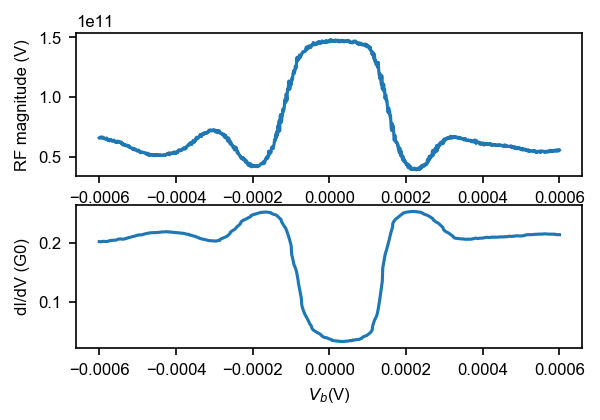

In [76]:
plt.figure()
plt.title('RF magnitude')
plt.subplot(211)
plt.plot(Vb, RF_mag_cal)
plt.ylabel('RF magnitude (V)')
plt.subplot(212)
plt.plot(Vb, dIdV_cal)
plt.xlabel(r'$V_b$(V)')
plt.ylabel('dI/dV (G0)')

In [13]:
def convert_to_g(g_cal, RF_cal, RF_data):
    g_data = np.empty(len(RF_data))
    for i in range(len(RF_data)):
        idx_closest = np.argmin(abs(RF_cal - RF_data[i]))
        g_data[i] = g_cal[idx_closest]
    return g_data

In [77]:
npoints = len(dIdV_cal)
i = np.nonzero(max(dIdV_cal)==dIdV_cal)
m = i[0][0]
print(npoints,np.nonzero(max(dIdV_cal)==dIdV_cal), m)

1001 (array([682], dtype=int64), array([0], dtype=int64)) 682


Text(0.5,0,'$V_b$(V)')

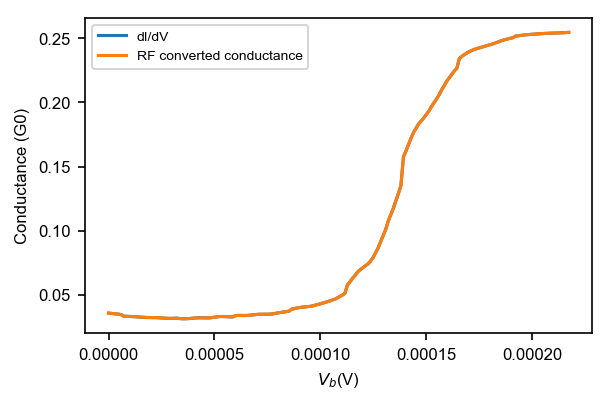

In [78]:
g_converted = convert_to_g(dIdV_cal[int(npoints/2):m], RF_mag_cal[int(npoints/2):m], RF_mag_cal[int(npoints/2):m])
plt.figure()
plt.plot(Vb[int(npoints/2):m], dIdV_cal[int(npoints/2):m], label='dI/dV')
plt.plot(Vb[int(npoints/2):m], g_converted, label='RF converted conductance')
plt.ylabel('Conductance (G0)')
plt.legend(fontsize='small')
plt.xlabel(r'$V_b$(V)')

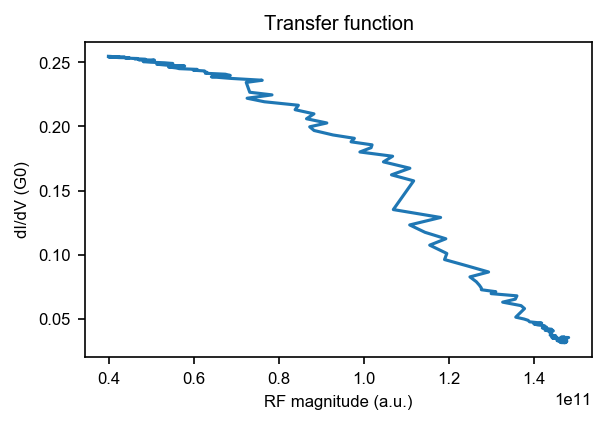

In [79]:
plt.figure()
plt.title('Transfer function')
plt.plot(RF_mag_cal[int(npoints/2):m], dIdV_cal[int(npoints/2):m])
plt.xlabel('RF magnitude (a.u.)')
plt.ylabel('dI/dV (G0)')
RF_calibration = RF_mag_cal[int(npoints/2):m]
dIdV_calibration = dIdV_cal[int(npoints/2):m]

In [80]:
s = smooth(RF_calibration.flatten(), 11,1)
c_s = smooth(dIdV_calibration.flatten(), 11,1)

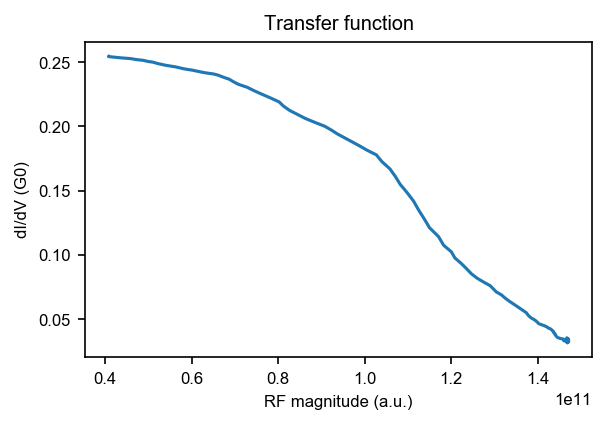

In [81]:
plt.figure()
plt.title('Transfer function')
plt.plot(s, c_s)
plt.xlabel('RF magnitude (a.u.)')
plt.ylabel('dI/dV (G0)')
RF_calibration = s
dIdV_calibration = c_s

In [48]:
from math import factorial
def smooth(y, window_size, order, deriv=0, rate=1):
    #try:
    window_size = np.abs(np.int(window_size))
    order = np.abs(np.int(order))
    #except ValueError, msg:
    #    raise ValueError("window_size and order have to be of type int")
    #if window_size % 2 != 1 or window_size < 1:
    #    raise TypeError("window_size size must be a positive odd number")
    #if window_size < order + 2:
    #    raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

### New data conversion

In [96]:
dat = load_by_id(442)
dat.get_parameters

Vb = dat.get_values('ivvi_setup_dac3')
RF = np.power(10,dat.get_values('logmag_dev48'))
#lockin_X = np.array(dat.get_values('ivvi_setup_g2_measurement'))
Rs = 18e3 + 3.4e3 + 20
Vac = 10e-6
#dIdV = lockin_X #-12906/(Vac/(lockin_X/1e8) - Rs)

In [97]:
cut = 10 #cut at the beginning of the trace

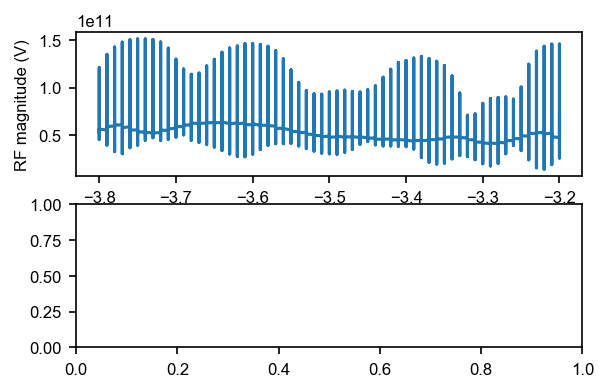

In [98]:
plt.figure()
plt.title('RF magnitude')
plt.subplot(211)
plt.plot(Vb[cut:], RF[cut:])
plt.ylabel('RF magnitude (V)')
plt.subplot(212)
#plt.plot(Vb[cut:], dIdV[cut:])
#plt.ylabel('dI/dV (G0)')
#plt.xlabel(r'$V_b$(V)')

Text(0,0.5,'Conductance (G0)')

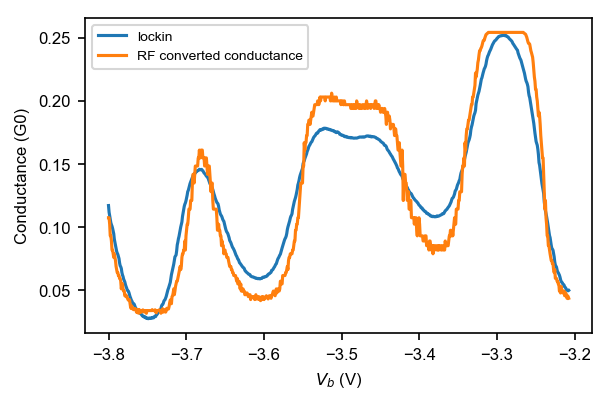

In [85]:
g_conv = convert_to_g(dIdV_calibration, RF_calibration, RF[10:])
plt.figure()
plt.plot(Vb[cut:], dIdV[cut:], label='lockin')
plt.plot(Vb[cut:], g_conv, label='RF converted conductance')
plt.legend(fontsize='small')
plt.xlabel(r'$V_b$ (V)')
plt.ylabel('Conductance (G0)')

#### 2D sweeps

In [114]:
#lockin
dat_dc = load_by_id(443)
print(dat_dc.get_parameters)

Vb = dat_dc.get_values('v_g')*2
Vg = dat_dc.get_values('ivvi_setup_dac3')
lockin_X = np.array(dat_dc.get_values('v_sd_2'))
Rs = 18e3 + 3.4e3 + 20
Vac = 10e-6
dIdV = lockin_X #-12906/(Vac/(lockin_X/1e8) - Rs)

<bound method DataSet.get_parameters of results #443@d:/OneDrive/BF2/Data/experiments.db
------------------------------------------------
v_g - numeric
i_avg - numeric
ivvi_setup_dac3 - numeric
v_sd_1 - numeric
v_sd_2 - numeric
v_sd_3 - numeric>


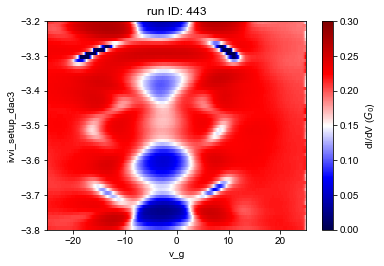

In [173]:
colorplot(dat_dc, 'v_g', 'ivvi_setup_dac3', 'v_sd_2')

In [115]:
#RF
dat_RF = load_by_id(442)
dat_RF.get_parameters

Vb = dat_RF.get_values('v_g')*2
Vg = dat_RF.get_values('ivvi_setup_dac3')
RF = np.power(10,dat_RF.get_values('logmag_dev48'))

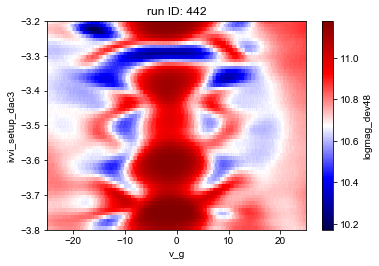

In [137]:
colorplot(dat_RF, 'v_g', 'ivvi_setup_dac3', 'logmag_dev48')

In [140]:
g_conv = convert_to_g(dIdV_calibration, RF_calibration, RF)

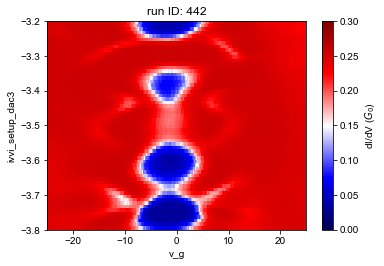

In [174]:
colorplot(dat_RF, 'v_g', 'ivvi_setup_dac3', g_conv, d_z = True)

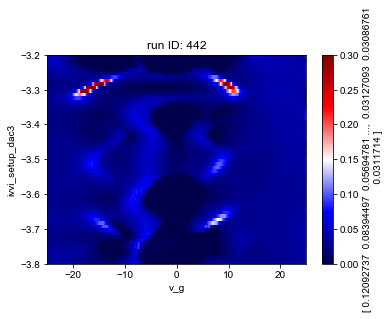

In [169]:
difference = g_conv-dIdV.flatten()
colorplot(dat_RF, 'v_g', 'ivvi_setup_dac3', difference, d_z = True)

In [162]:
g_conv?

In [164]:
RF?

In [67]:
np.mean(abs(dIdV-g_conv)/dIdV)

1.0947986242749719

In [93]:
1/np.sqrt(420e-9*1.5e-12)/(2*np.pi)/1e6

200.51638064180588

In [94]:
420e-9/1.5e-12/50

5600.0

### John example

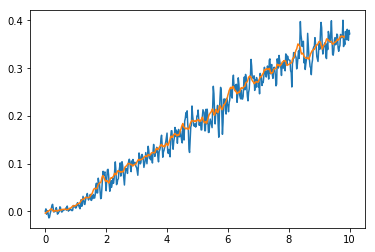

In [6]:
# didv_smooth = pd.rolling_mean(didv, 10)
didv_smooth = pd.Series(didv).rolling(10).mean()

plt.plot(Vg, didv)
plt.plot(Vg, didv_smooth)
plt.show()

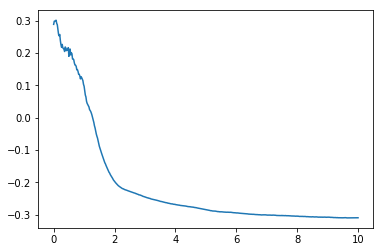

In [7]:
plt.plot(Vg, RF)
plt.show()

In [8]:
def convert_to_g(g_cal, RF_cal, RF_data):
    g_data = np.empty(len(RF_data))
    for i in range(len(RF_data)):
        idx_closest = np.argmin(abs(RF_cal - RF_data[i]))
        g_data[i] = g_cal[idx_closest]
    return g_data

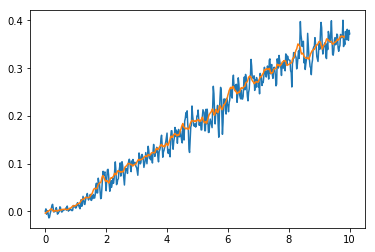

In [9]:
g_converted = convert_to_g(didv_smooth, RF, RF)
plt.plot(Vg, didv)
plt.plot(Vg, g_converted)
plt.show()

In [10]:
#File info
DIR = r"C:\Users\jowat\data\Data exports"
filename_g = 'SagRes0122_DEV5_12_didv.txt'
filename_rf = 'SagRes0122_DEV5_12_RF.txt'
filepath_g = os.path.join(DIR, filename_g)
filepath_rf = os.path.join(DIR, filename_rf)


data_g = np.genfromtxt(filepath_g, delimiter='\t', skip_header=8)
data_rf = np.genfromtxt(filepath_rf, delimiter='\t', skip_header=8)

In [11]:
xmin = -0.01
xmax = 0.01
Nx = 201+1
ymin = 0
ymax = 10
Ny = 101

x = np.linspace(xmin, xmax, Nx)
y = np.linspace(ymin, ymax, Ny)

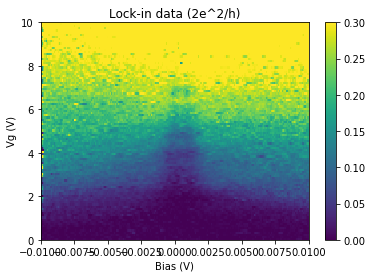

In [12]:
plt.pcolormesh(x,y,data_g, vmin=0, vmax=0.3)
plt.xlabel('Bias (V)')
plt.ylabel('Vg (V)')
plt.colorbar()
plt.title('Lock-in data (2e^2/h)')
plt.show()

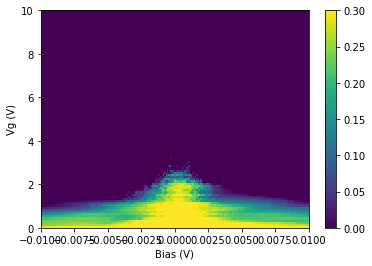

In [13]:
plt.pcolormesh(x,y,data_rf, vmin=0, vmax=0.3)
plt.xlabel('Bias (V)')
plt.ylabel('Vg (V)')
plt.colorbar()
plt.show()

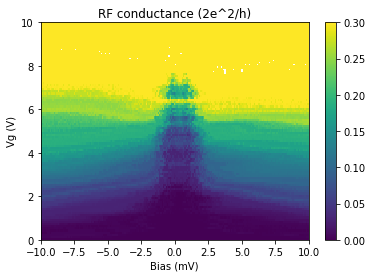

In [14]:
g_converted = np.empty([np.shape(data_g)[0],np.shape(data_g)[1]])
for i in range(len(data_g[0,:])):
    g_converted[:,i] = convert_to_g(didv_smooth, RF, data_rf[:,i])

plt.pcolormesh(x*1000,y,g_converted, vmin=0, vmax=0.3)
plt.xlabel('Bias (mV)')
plt.ylabel('Vg (V)')
plt.title('RF conductance (2e^2/h)')
plt.colorbar()
plt.show()

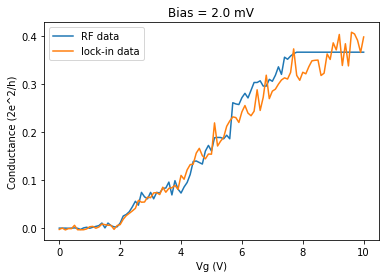

In [15]:
bias_cut = 2e-3
index = np.argmin(abs(x - bias_cut))

plt.plot(y, convert_to_g(didv_smooth, RF, data_rf[:,index]), label='RF data')
plt.plot(y, data_g[:,index], label='lock-in data')
plt.xlabel('Vg (V)')
plt.ylabel('Conductance (2e^2/h)')
plt.legend()
plt.title('Bias = ' + str(bias_cut*1000) +' mV')
plt.show()

In [16]:
len(x)

202

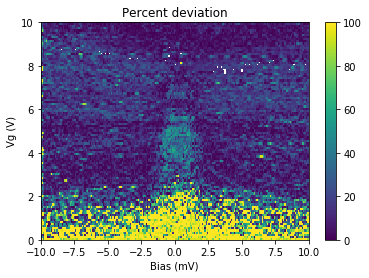

In [17]:
deviation = 100*abs((data_g - g_converted)/data_g)
plt.pcolormesh(x*1000, y, deviation, vmin=0, vmax=100)
plt.colorbar()
plt.xlabel('Bias (mV)')
plt.ylabel('Vg (V)')
plt.title('Percent deviation')
plt.show()

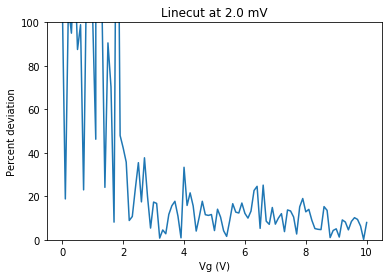

In [18]:
bias_cut = 2e-3
index = np.argmin(abs(x-bias_cut))

plt.plot(y, deviation[:, index])
plt.xlabel('Vg (V)')
plt.ylabel('Percent deviation')
plt.ylim([0,100])
plt.title('Linecut at ' + str(bias_cut*1000) +' mV')
plt.show()

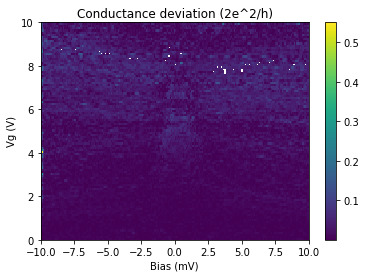

In [19]:
g_deviation = abs(data_g - g_converted)
plt.pcolormesh(x*1000, y, g_deviation)
plt.colorbar()
plt.xlabel('Bias (mV)')
plt.ylabel('Vg (V)')
plt.title('Conductance deviation (2e^2/h)')
plt.show()

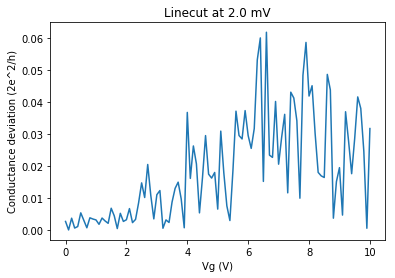

In [20]:
bias_cut = 2e-3
index = np.argmin(abs(x-bias_cut))

plt.plot(y, g_deviation[:, index])
plt.xlabel('Vg (V)')
plt.ylabel('Conductance deviation (2e^2/h)')
plt.title('Linecut at ' + str(bias_cut*1000) +' mV')
plt.show()

## Conversion as in Harabula et al

1) Import file with DC conductance

2) mport file with RF conductance

3) Plot the 2 together

4) Try the fitting

Work with run_ID 593 (DC) and 597 (RF, alazar), 0 field


### Useful functions

In [1]:
def find_nearest(array, value):
    idx_closest = np.argmin(abs(array - value))
    return idx_closest

def return_idx_array(array, value_array):
    idx = []
    for k in range(np.size(value_array)):
        idx.append(find_nearest(array,value_array[k]))
    return idx

In [2]:
e = 1.6e-19
h = 6.6e-34

### Alazar data

In [3]:
dat_DC = load_by_id(593)
dat_DC.get_parameters()

[ivvi_dac7 (numeric), ivvi_setup_g2_measurement (numeric)]

In [17]:
dac = np.array(dat_DC.get_data('ivvi_dac7'))*5/1000
cond = np.array(dat_DC.get_data('ivvi_setup_g2_measurement'))*2*e**2/h
R = 1/cond

<IPython.core.display.Javascript object>


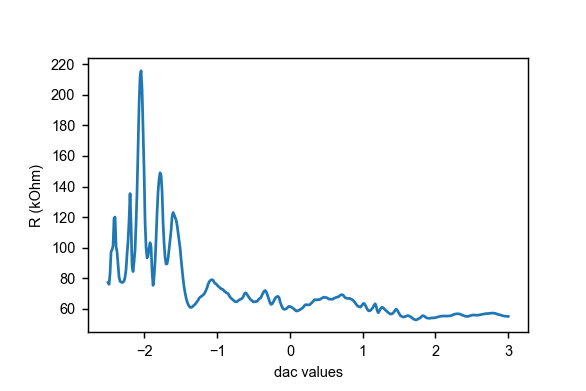

Text(0,0.5,'R (kOhm)')

In [18]:
plt.figure()
plt.plot(dac,R/1e3)
plt.xlabel('dac values')
plt.ylabel('R (kOhm)')

In [11]:
dat_RF = load_by_id(597)
dat_RF.get_parameters()

[ivvi_dac7 (numeric),
 sequence_awg_sweep_idx (numeric),
 detector_channels (numeric),
 detector_signal_real (numeric),
 detector_signal_imag (numeric),
 detector_signal_abs (numeric),
 detector_signal_phase (numeric)]

In [12]:
inner_1 = np.unique(np.array(dat_RF.get_data("sequence_awg_sweep_idx"))*2/100)
inner_2 = np.unique(np.array(dat_RF.get_data("ivvi_dac7"))*5/1000) #plunger
#inner_3 = np.unique(np.array(dat_RF.get_data("ivvi_dac6"))*5/1000) #cutter
RF = np.array(dat_RF.get_data('detector_signal_abs'))

In [15]:
loop = inner_1
value = 0
idx = find_nearest(loop,value)

y = RF.reshape(len(inner_2), len(inner_1), 2)

<IPython.core.display.Javascript object>


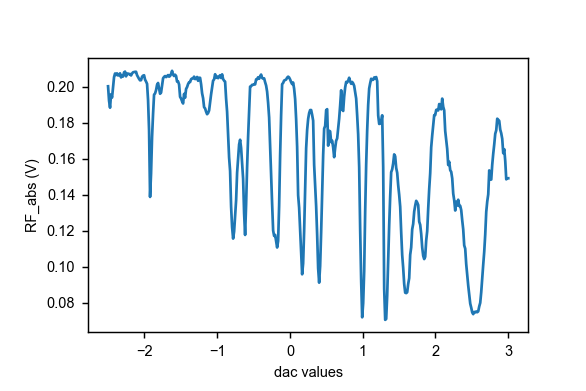

Text(0,0.5,'RF_abs (V)')

In [23]:
y1 = y[:,:,0]
y2 = y[:,:,1]
y_p = np.sqrt(y1**2+y2**2)
plt.figure()
plt.plot(inner_2,y_p)
plt.xlabel('dac values')
plt.ylabel('RF_abs (V)')

<IPython.core.display.Javascript object>


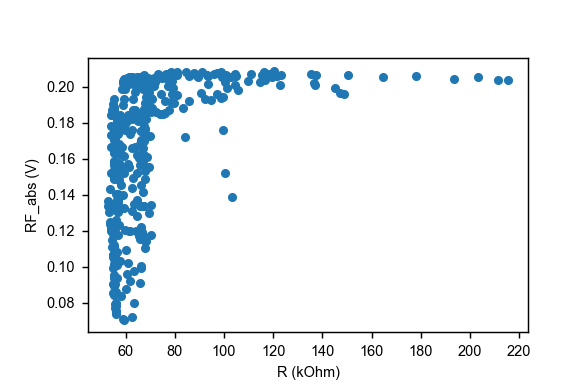

Text(0,0.5,'RF_abs (V)')

In [24]:
plt.figure()
plt.plot(R/1e3,y_p, 'o')
plt.xlabel('R (kOhm)')
plt.ylabel('RF_abs (V)')

### MIDAS data
(MIDAS has already S11 somehow)

Run_IDs 413 (has both DC and RF for calibration) and 442 (has also both, to try the goodness of the conversion)

In [7]:
dat = load_by_id(413)
dat.get_parameters()

[yoko_voltage (numeric),
 logmag_dev48 (numeric),
 phase_dev48 (numeric),
 logmag_dev12 (numeric),
 phase_dev12 (numeric),
 ivvi_setup_g3_measurement (numeric),
 ivvi_setup_g2_measurement (numeric)]

In [8]:
Vb = dat.get_values('yoko_voltage') #ivvi_setup_dac1
RF_mag_cal = np.power(10,np.array(dat.get_data('logmag_dev48'))/10)
lockin_X_cal = np.array(dat.get_data('ivvi_setup_g2_measurement')) #lockin3_X
Rs = 18e3 + 3.4e3 + 20
Vac = 10e-6
dIdV_cal = lockin_X_cal #-12906/(Vac/(lockin_X_cal/1e8) - Rs)
R = 1/(dIdV_cal*2*e**2/h)
RF_phase_cal = np.array(dat.get_data('phase_dev48'))

<IPython.core.display.Javascript object>


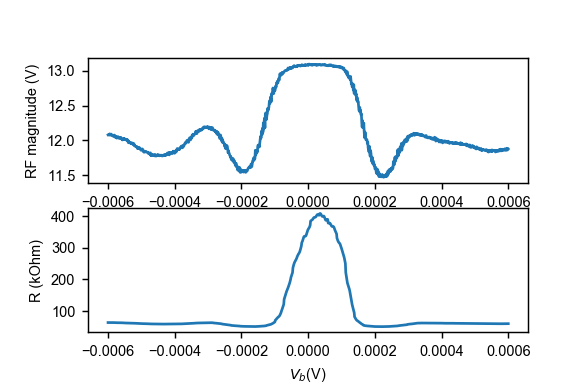

<IPython.core.display.Javascript object>


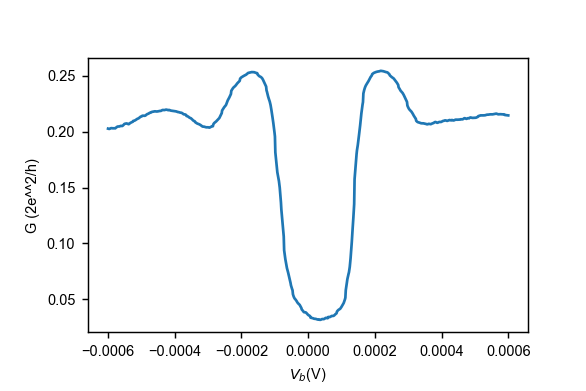

<IPython.core.display.Javascript object>


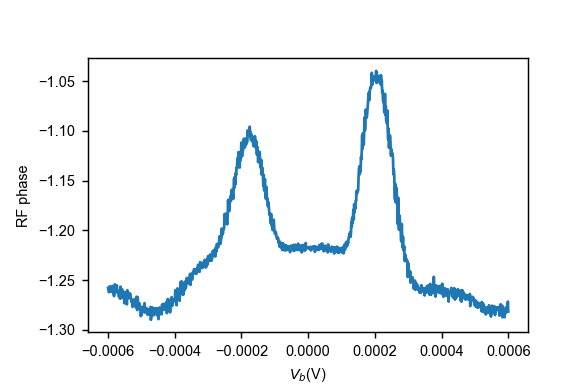

<IPython.core.display.Javascript object>


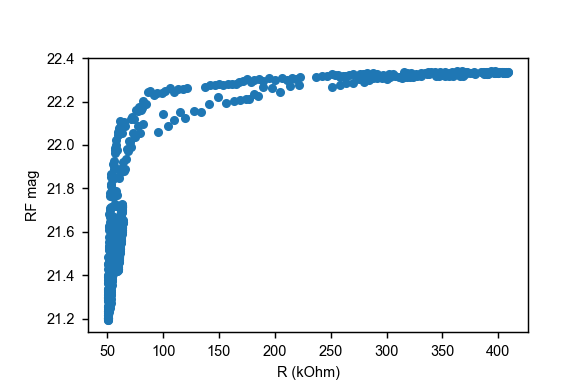

Text(0,0.5,'RF mag')

In [32]:
plt.figure()
plt.title('RF magnitude')
plt.subplot(211)
plt.plot(Vb, RF_mag_cal)
plt.ylabel('RF magnitude (V)')
plt.subplot(212)
plt.plot(Vb, R/1e3)
plt.xlabel(r'$V_b$(V)')
plt.ylabel('R (kOhm)')

plt.figure()
plt.plot(Vb, dIdV_cal)
plt.xlabel(r'$V_b$(V)')
plt.ylabel(r'G (2e^^2/h)')

plt.figure()
plt.plot(Vb,RF_phase_cal)
plt.xlabel(r'$V_b$(V)')
plt.ylabel(r'RF phase')

plt.figure()
plt.plot(R/1e3, 10*np.log10(RF_mag_cal**2), 'o')
plt.xlabel(r'R (kOhm)')
plt.ylabel(r'RF mag')

In [25]:
from scipy.optimize import curve_fit

def gamma_VNA_fit(r, att, l, c, f_res=228e6):
    w_res = 2*np.pi*f_res #np.sqrt(1/l/c)
    z = w_res*l*1j + r/(w_res*c*1j)/(1/(w_res*c*1j)+r)
    g = (z-50)/(z+50)
    return 10*np.log10(att*np.absolute(g)**2)

In [47]:
y_fit = 10*np.log10(RF_mag_cal**2)

In [48]:
R_flat = R.flatten()
y_flat = y_fit.flatten()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


<IPython.core.display.Javascript object>


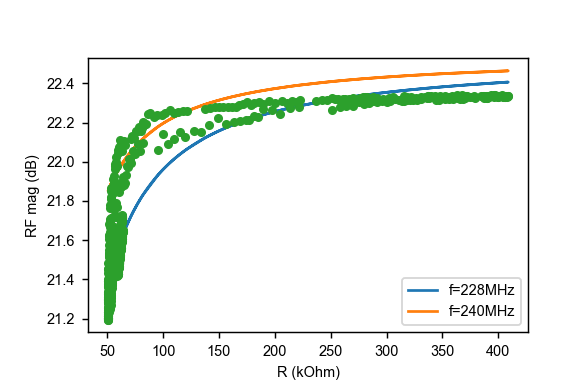

[  1.79887463e+02  -2.85169296e-07  -1.68360563e-12]


In [49]:
cut=0
popt,pcov = curve_fit(gamma_VNA_fit, R_flat[cut:-1], y_flat[cut:-1], p0 = [1e3, 310e-9, 1.6e-12]) #, p0 = [0.003, 100e-9, 50e-15]) #, bounds = (0,1)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(R[cut:-1]/1e3, gamma_VNA_fit(R[cut:-1],popt[0],np.absolute(popt[1]),np.absolute(popt[2]), f_res=228e6), label='f=228MHz')
#plt.plot(R[cut:-1], gamma_VNA_fit(R[cut:-1],popt[0],np.absolute(popt[1]),np.absolute(popt[2]), f_res=230e6), label='f=230MHz')
plt.plot(R[cut:-1]/1e3, gamma_VNA_fit(R[cut:-1],popt[0],np.absolute(popt[1]),np.absolute(popt[2]), f_res=240e6), label='f=240MHz')
plt.plot(R[cut:-1]/1e3, y_fit[cut:-1], 'o')
plt.legend()
plt.xlabel(r'R (kOhm)')
plt.ylabel(r'RF mag (dB)')

print(popt)

In [112]:
L= 285e-9
C= 1.68e-12
f = np.sqrt(1/(L*C))/2/np.pi
print(f/1e6)

230.00806309


In [60]:
R_scaled = R[50]
R_scaled= np.append(R_scaled,R[801:-1])

RF_scaled = RF_mag_cal[50]
RF_scaled= np.append(RF_scaled,RF_mag_cal[801:-1])

In [62]:
len(RF_scaled)

200

<IPython.core.display.Javascript object>


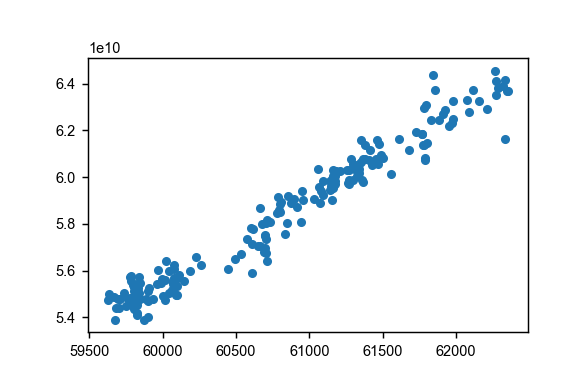

In [64]:
plt.figure()
plt.plot(R_scaled,RF_scaled,'o')